# Bike Supply

## Summary

Bike Supply is a PyMC3-driven Bayesian predictive model of an urban bike share company's supply-demand dynamics. This model was built using public data supplied by Bay Area Bike Share. This model was built to answer the question - is it possible to build a model that predicts the volume of bikes entering and leaving a station for any given day of the year?

Bike sharing programs have the unique challenge of needing to ensure bikes and docking stations are available throughout the city for users throughout the day, even though users have the freedom to choose their own destinations rental by rental. 

## Data munging

## Overview

In [64]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

data = pd.read_csv('trips.csv')

In [65]:
data[0:3]

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,650330,495,2015-02-19 15:46:00 UTC,Yerba Buena Center of the Arts (3rd @ Howard),68,2015-02-19 15:54:00 UTC,San Francisco Caltrain 2 (330 Townsend),69,463,94061,Subscriber
1,367544,241,2014-07-17 08:09:00 UTC,San Francisco Caltrain 2 (330 Townsend),69,2014-07-17 08:13:00 UTC,Townsend at 7th,65,441,95120,Subscriber
2,586344,3589,2014-12-27 16:01:00 UTC,Embarcadero at Bryant,54,2014-12-27 17:01:00 UTC,2nd at Townsend,61,466,27401,Customer


In [66]:
print "Number of stations:", len(data.start_station_name.unique())
print "Number of bikes:", len(data.bike_number.unique())
print "Number of trips logged:", len(data)

Number of stations: 84
Number of bikes: 700
Number of trips logged: 983648


In [67]:
# Remove UTC from datatime !!Don't do this more than once!!
data['start_date'] = data['start_date'].astype(str).str[:-3]

In [68]:
data['start_date'] = pd.to_datetime(data['start_date'])

In [69]:
data['end_date'] = pd.to_datetime(data['end_date'])

In [70]:
data[0:3]

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,650330,495,2015-02-19 15:46:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2015-02-19 15:54:00,San Francisco Caltrain 2 (330 Townsend),69,463,94061,Subscriber
1,367544,241,2014-07-17 08:09:00,San Francisco Caltrain 2 (330 Townsend),69,2014-07-17 08:13:00,Townsend at 7th,65,441,95120,Subscriber
2,586344,3589,2014-12-27 16:01:00,Embarcadero at Bryant,54,2014-12-27 17:01:00,2nd at Townsend,61,466,27401,Customer


In [71]:
print "Number of years in dataset:", len(data.start_date.dt.year.unique())

Number of years in dataset: 4


In [72]:
data['start_just_date'] = data.start_date.dt.date

In [97]:
data['end_just_date'] = data.end_date.dt.date

In [74]:
data['year'] = data.start_date.dt.year

In [75]:
data['month'] = data.start_date.dt.month

In [76]:
data['start_day'] = data.start_date.dt.day

In [77]:
data['start_time'] = data.start_date.dt.time

In [78]:
data['end_day'] = data.end_date.dt.day

In [79]:
data['end_time'] = data.end_date.dt.time

In [80]:
data[0:5]

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type,start_just_date,end__just_date,year,month,start_day,start_time,end_day,end_time
0,650330,495,2015-02-19 15:46:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2015-02-19 15:54:00,San Francisco Caltrain 2 (330 Townsend),69,463,94061,Subscriber,2015-02-19,2015-02-19,2015,2,19,15:46:00,19,15:54:00
1,367544,241,2014-07-17 08:09:00,San Francisco Caltrain 2 (330 Townsend),69,2014-07-17 08:13:00,Townsend at 7th,65,441,95120,Subscriber,2014-07-17,2014-07-17,2014,7,17,08:09:00,17,08:13:00
2,586344,3589,2014-12-27 16:01:00,Embarcadero at Bryant,54,2014-12-27 17:01:00,2nd at Townsend,61,466,27401,Customer,2014-12-27,2014-12-27,2014,12,27,16:01:00,27,17:01:00
3,772874,733,2015-05-19 09:50:00,Davis at Jackson,42,2015-05-19 10:02:00,2nd at Townsend,61,501,94111,Subscriber,2015-05-19,2015-05-19,2015,5,19,09:50:00,19,10:02:00
4,419431,302,2014-08-21 19:11:00,5th at Howard,57,2014-08-21 19:16:00,San Francisco Caltrain (Townsend at 4th),70,392,95110,Subscriber,2014-08-21,2014-08-21,2014,8,21,19:11:00,21,19:16:00


In [81]:
data['trip_length'] = data['end_date'] - data['start_date']

In [82]:
data['trip_length'][0:10]

0   00:08:00
1   00:04:00
2   01:00:00
3   00:12:00
4   00:05:00
5   00:05:00
6   00:20:00
7   00:06:00
8   00:15:00
9   00:07:00
Name: trip_length, dtype: timedelta64[ns]

In [83]:
max(data['trip_length'])

Timedelta('199 days 22:19:00')

In [84]:
min(data['trip_length'])

Timedelta('0 days 00:01:00')

In [85]:
# Convert timestamp to seconds

data['trip_length'] = data['trip_length'].astype('timedelta64[s]')

In [86]:
max(data['trip_length'])

17273940.0

In [87]:
min(data['trip_length'])

60.0

In [88]:
longer_than_one_day = data.query("trip_length >= 86400")

In [89]:
len(longer_than_one_day)

297

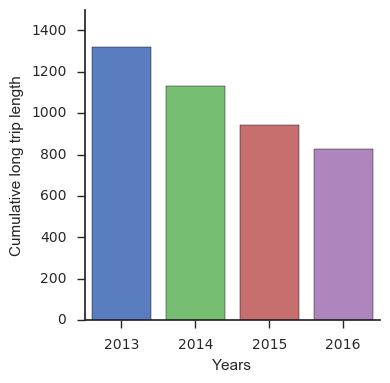

In [90]:
# Are they all from one year or across the whole timeframe? PLOT
import seaborn as sns

g = sns.factorplot(x="year", y="trip_length", kind="bar", data=data, ci=None, palette="muted")
g.set_xlabels("Years")
g.set_ylabels("Cumulative long trip length")
g.set(ylim = (0,1500))

In [91]:
#Seems this might be some kind of outlier experience that is decreasing as the business grows
#Maybe I cut it too close to the bone, let me try within 2 days (to include overnight trips)

longer_than_two_days = data.query("trip_length >= 172800")
len(longer_than_two_days)

138

In [92]:
#At this point, I mostly care about 2015 and 2016, so let me plot all points less than 2 days and look at the data

# less_than_two_days = data.query("trip_length <= 172800")

less_than_two_days = data[(data['trip_length'] <= 172800) & (data['year'] == 2016)]

In [109]:
data['end_yyyymmdd'] = (
    data['end_date'].dt.year.astype(str) + 
    data['end_date'].dt.month.astype(str).str.zfill(2) + 
    data['end_date'].dt.day.astype(str).str.zfill(2))

In [111]:
data['end_yyyymmdd'] = data['end_yyyymmdd'].astype(int)

In [112]:
less_than_two_days = data[(data['trip_length'] <= 172800) & (data['year'] == 2016)]

In [113]:
less_than_two_days

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,...,year,month,start_day,start_time,end_day,end_time,trip_length,end_just_date,end_yyyy-mm-dd,end_yyyymmdd
10,1279437,1017,2016-07-16 16:05:00,Powell Street BART,39,2016-07-16 16:21:00,Civic Center BART (7th at Market),72,441,92844,...,2016,7,16,16:05:00,16,16:21:00,960.0,2016-07-16,2016-07-16,20160716
21,1189381,510,2016-05-05 12:00:00,Yerba Buena Center of the Arts (3rd @ Howard),68,2016-05-05 12:09:00,Embarcadero at Folsom,51,635,2130,...,2016,5,5,12:00:00,5,12:09:00,540.0,2016-05-05,2016-05-05,20160505
27,1225665,577,2016-06-03 11:55:00,Embarcadero at Sansome,60,2016-06-03 12:05:00,Harry Bridges Plaza (Ferry Building),50,510,94040,...,2016,6,3,11:55:00,3,12:05:00,600.0,2016-06-03,2016-06-03,20160603
28,1196140,400,2016-05-11 08:56:00,Temporary Transbay Terminal (Howard at Beale),55,2016-05-11 09:02:00,5th at Howard,57,527,94103,...,2016,5,11,08:56:00,11,09:02:00,360.0,2016-05-11,2016-05-11,20160511
30,1220829,194,2016-05-31 12:47:00,Commercial at Montgomery,45,2016-05-31 12:51:00,Davis at Jackson,42,620,94965,...,2016,5,31,12:47:00,31,12:51:00,240.0,2016-05-31,2016-05-31,20160531
32,1057450,720,2016-01-11 17:47:00,Clay at Battery,41,2016-01-11 17:59:00,2nd at Townsend,61,378,94022,...,2016,1,11,17:47:00,11,17:59:00,720.0,2016-01-11,2016-01-11,20160111
35,1208884,534,2016-05-20 07:58:00,2nd at Townsend,61,2016-05-20 08:07:00,Embarcadero at Folsom,51,350,95148,...,2016,5,20,07:58:00,20,08:07:00,540.0,2016-05-20,2016-05-20,20160520
41,1140657,1368,2016-03-29 07:53:00,Temporary Transbay Terminal (Howard at Beale),55,2016-03-29 08:16:00,Market at 10th,67,380,94602,...,2016,3,29,07:53:00,29,08:16:00,1380.0,2016-03-29,2016-03-29,20160329
47,1130485,900,2016-03-19 16:14:00,Powell at Post (Union Square),71,2016-03-19 16:29:00,Grant Avenue at Columbus Avenue,73,470,90049,...,2016,3,19,16:14:00,19,16:29:00,900.0,2016-03-19,2016-03-19,20160319
48,1093012,330,2016-02-14 13:58:00,Harry Bridges Plaza (Ferry Building),50,2016-02-14 14:03:00,Harry Bridges Plaza (Ferry Building),50,604,92647,...,2016,2,14,13:58:00,14,14:03:00,300.0,2016-02-14,2016-02-14,20160214


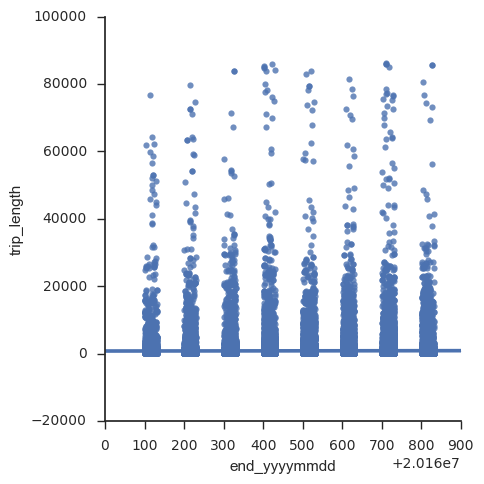

In [114]:
sns.lmplot('end_yyyymmdd', 'trip_length', data=less_than_two_days)

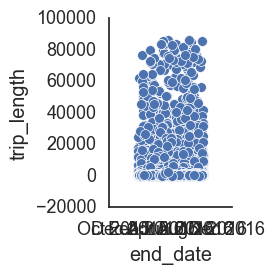

In [134]:
#kws = dict(s=50, linewidth=.5, edgecolor="w")
#g = sns.FacetGrid(less_than_two_days)
#g = (g.map(plt.scatter,'end_date', 'trip_length',**kws))

## EDA

The big question I have on the onset of this research is how granular do we need to get in our model?

* Are the dyanmics similar enough across stations such that they can all be included in the same model, or do we need to build models for clusters of stations? We will try some logical groupings to see if there are any global patterns of dynamics across them. 

* Weekday-Weekend? Day by day? Month by month? Seasonality? Let's do some side-by-side visualizations of these time periods to see if any trends emerge. 

* How granular should we be in time bins (1 hour bins, 10 minutes, 1 minute)? I think some simple histograms can help us identity the kinds of volume of activity we are seeing. 

I'm curious about the number of bikes in the fleet, month by month, year by year. I think his may map onto the growth of the company, and that there may be different dynamics at each scale of growth. This is a big question I have with this data going forward - how will this prediction model scale? I'd love to work closely with the company to observe such shifts. 


## Simple model (unaware) - historical data

Inspired by our Python maxim of KISS, let's begin by building a simple model that predicts station inputs and outputs based on hourly averages for each station. To help us out a little, we'll follow our intuition and segment weekend from weekday data, creating two spearate predictors. This first model will be network unaware, meaning we will look only at historical rentals and returns for each station, and not adjust our predictions based on what we know is happening at other stations in real time. 

For our averages we will use annual averages from 2015, and plot these alongside 2016 data points to see if our averages serve as accurate predictors. 

## Simple model (aware) - historical + "real-time" data

This model makes predictions based on the behavior of other stations in the network in real time, and takes a step closer to our Bayesian model. Still relying on annual averages from 2015 to predict departures, this model builds up a prediction of arrivals based on the sum of a weighted factor that is a product of the distribution of journey destinations (by hour) for each station, the number of bikes leaving those station (at each hour interval), and the average bike trip length for that hour interval (which will determine when the bike is predicted to arrive at its destination). NOTE: I put "real-time" in quotes, because this model is still being simulated with historical data. However, the attempt with this model is to simulate what could be done in real time.

## Bayesian model (2015 priors)

We will get a bit more granular in our setting of priors - taking some of the seasonality and day of the week trends we spotted in our EDA. Our hyperparameters of the prior distribution will be set on 2015 data, with our tau coming from the granularity we are choosing (day by day, season by season, etc.). We assume our bike rentals are Poisson-distributed. 

The goal is predict lambdas of net traffic (arrivals - departures) for each station. In the end, we will have generated 84 lambdas, illustrating the dynamics we expect to see across our 84 stations, which we will plot against our 2016 data. 


## Bayesian model (live prior updating)

This is the model I am for ....

Each bike that leaves a station updates the prior probabilities for the model such that what we are seeing in our posterior distributions are based on the actual dynamics of that day. What is that called? Is that still a Bayesian model?

## General provisions

I'm not sure how to set a good prior, but I think 2015 data to predict 2016 seems good. I may want to try 2014 + 2015, but I think it all depends on what we observe in the EDA. 

* Adjust for Giants games (some stations).

* Adjust for weather. 

Distribution of precisions across 84 stations - and an average. 

Overall precision rating in reducing errors between prediction and observed - each model gets one score (we compare those scores). 

## References